### Урок 7. Детектирование объектов

In [1]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [2]:
from google.colab import files

In [3]:
import cv2 as cv

In [4]:
files.upload()

Saving 1200px-Newport_high_street.jpg to 1200px-Newport_high_street.jpg


{'1200px-Newport_high_street.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x90\x00\x90\x00\x00\xff\xfe\x00MFile source: http://commons.wikimedia.org/wiki/File:Newport_high_street.jpg\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x03\x84\x04\xb0\x03\x01!\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\xff\xc4\x00Q\x10\x00\x01\x03\x02\x04\x04\x03\x05\x05\x05\x05\x06\x04\x05\x01\t\x01\x02\x03\x11\x00\x04\x05\x12!1\x06\x13AQ"aq\x07\x142\x81\x91\x15#B\xa1\xb13Rb\xc1\xd1\x16$r\xe1\xf0\x084CS\x82\xf1\x17%&\x925DTcs6\x83\xa2\xb2\xd2\x18\'7\x93\xa3\xff\xc4\x00\x1a\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00

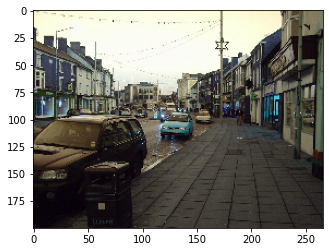

In [6]:
#Читаем картинку
im = cv.imread('/content/1200px-Newport_high_street.jpg')
    
# размеры изображения
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

In [7]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [8]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(1989, 4)


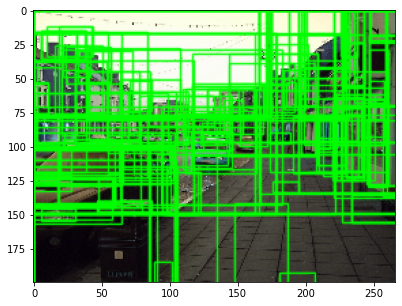

In [9]:
#Построим области

num_Rects = 200 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
  if (i < num_Rects): #пока не больше 
    # x,y - координаты левого верхнего угла; w, h - ширина и высота области
    x, y, w, h = rect
    # рисуем рамку      
    cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
  else: 
    break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
root_path = '/content/drive/MyDrive/Colab Notebooks/less_07/' 

### Формирование и обработка результатов детектирования

In [38]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Загрузка детектора

In [39]:
# справа в списке выбора можно поменять архитектуру на SSD или Faster F-CNN
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

Формируем тензор

In [40]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)  # алгоритм кодирования JPEG
  return img

Выполняем детектор на 100 рамок

In [41]:
max_frames = 100
def run_detector(detector, path):
  img = load_img(path)
  # превращаем изображение из целого в вещественное
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 
  
  # визуализация. Ограничиваем количество рамок 100
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

In [42]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [43]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

In [48]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]

array('/content/drive/My Drive/Colab Notebooks/less_07/1200px-Newport_high_street.jpg',
      dtype='<U78')

In [49]:
List_name[1]

array('/content/drive/My Drive/Colab Notebooks/less_07/26d613f0f63d4cecfc3fa21afd602bd8.jpg',
      dtype='<U84')

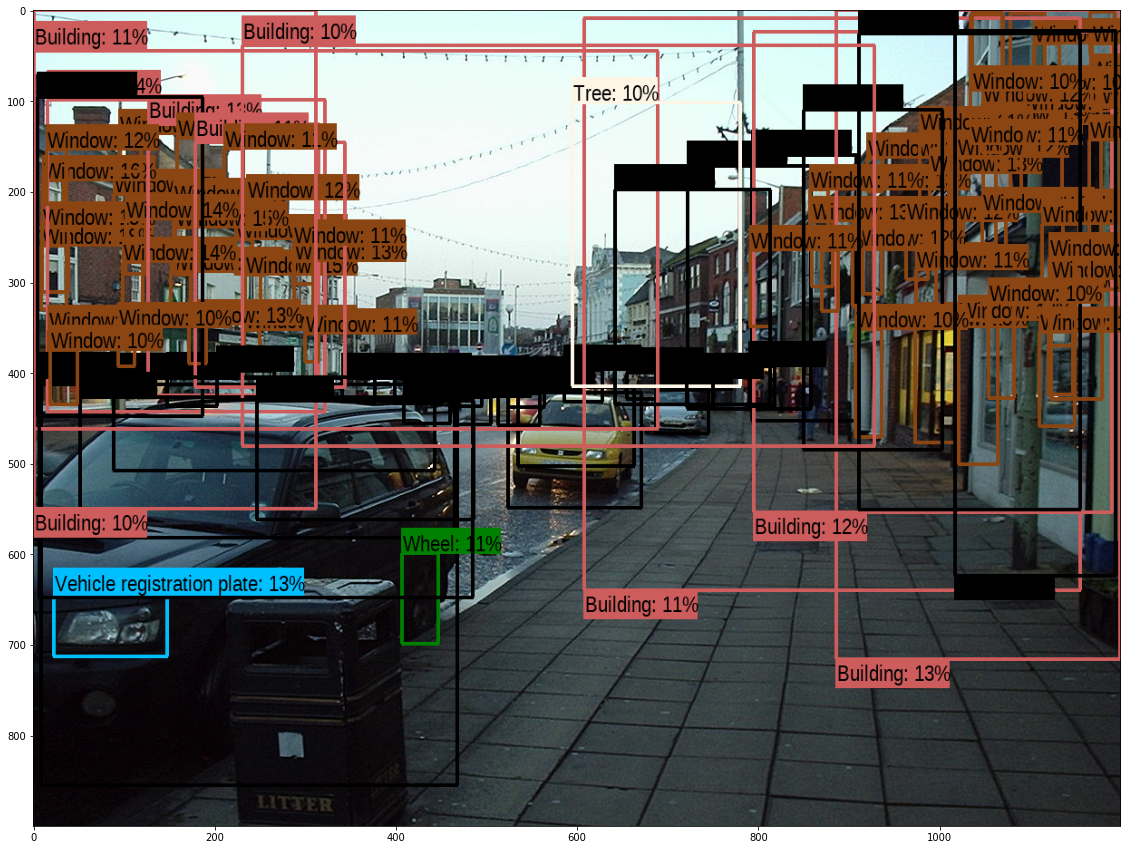

In [51]:
result_100 = run_detector(detector, List_name[0])

In [52]:
result_100

{'detection_class_names': array([b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j',
        b'/m/0k4j', b'/m/0k4j', b'/m/0d4v4', b'/m/0k4j', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0k4j', b'/m/03jm5', b'/m/0cgh4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/01jfm_', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/083wq',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0c

Выполняем детектор на 70 рамок

In [53]:
max_frames = 70
def run_detector(detector, path):
  img = load_img(path)
  # превращаем изображение из целого в вещественное
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 
  
  # визуализация. Ограничиваем количество рамок 50
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

In [54]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [55]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

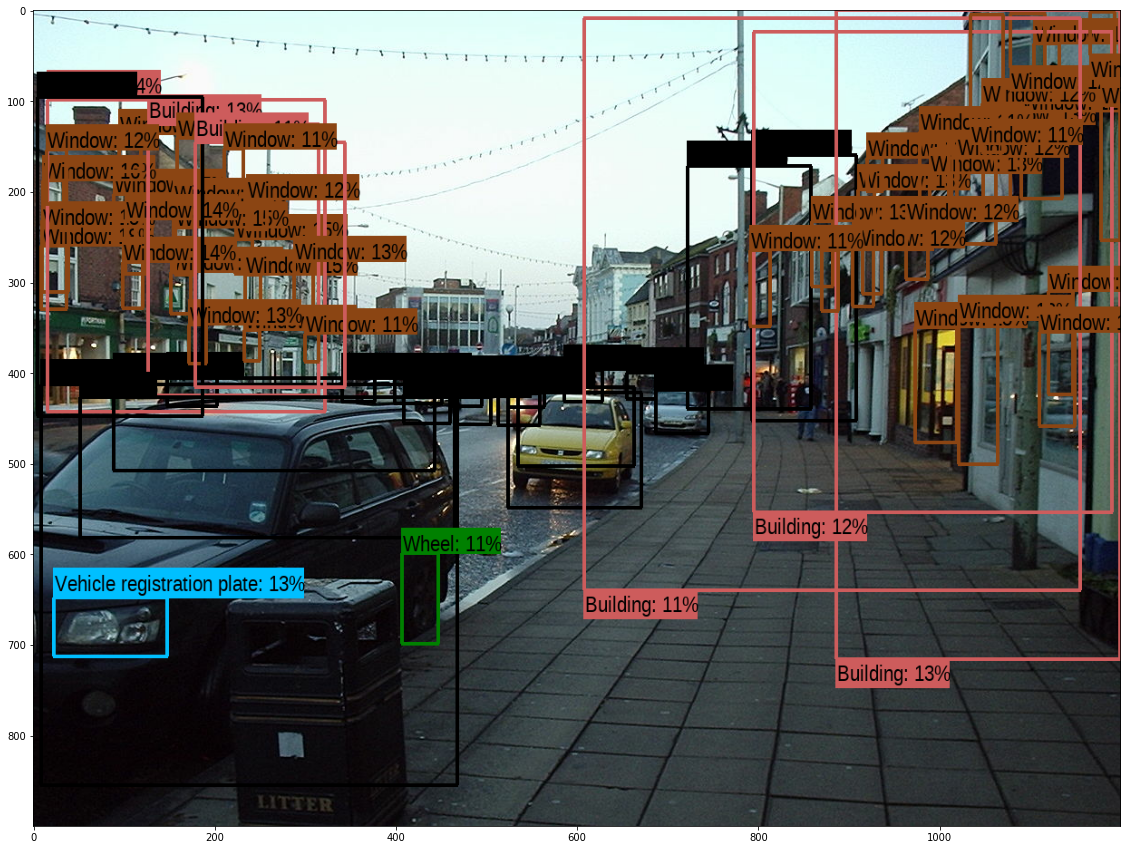

In [56]:
result_70 = run_detector(detector, List_name[0])


In [64]:
result_70

{'detection_class_names': array([b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j',
        b'/m/0k4j', b'/m/0k4j', b'/m/0d4v4', b'/m/0k4j', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0k4j', b'/m/03jm5', b'/m/0cgh4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/01jfm_', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/083wq',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0c

Выполняем детектор на 50 рамок

In [58]:
max_frames = 50
def run_detector(detector, path):
  img = load_img(path)
  # превращаем изображение из целого в вещественное
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 
  
  # визуализация. Ограничиваем количество рамок 50
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

In [59]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [60]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

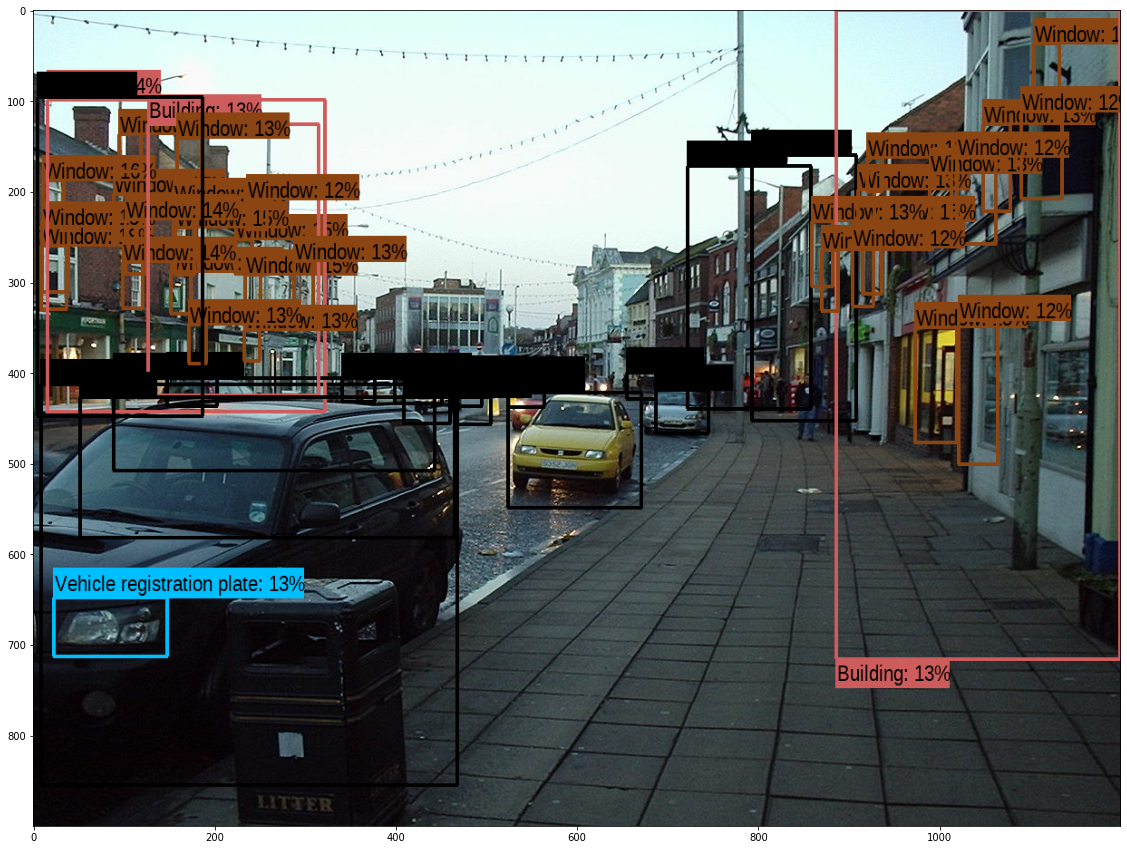

In [62]:
result_50 = run_detector(detector, List_name[0])

In [63]:
result_50

{'detection_class_names': array([b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j',
        b'/m/0k4j', b'/m/0k4j', b'/m/0d4v4', b'/m/0k4j', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0k4j', b'/m/03jm5', b'/m/0cgh4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/01jfm_', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/083wq',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0c

Выполняем детектор на 10 рамок

In [65]:
max_frames = 10
def run_detector(detector, path):
  img = load_img(path)
  # превращаем изображение из целого в вещественное
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 
  
  # визуализация. Ограничиваем количество рамок 10
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

In [66]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [67]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

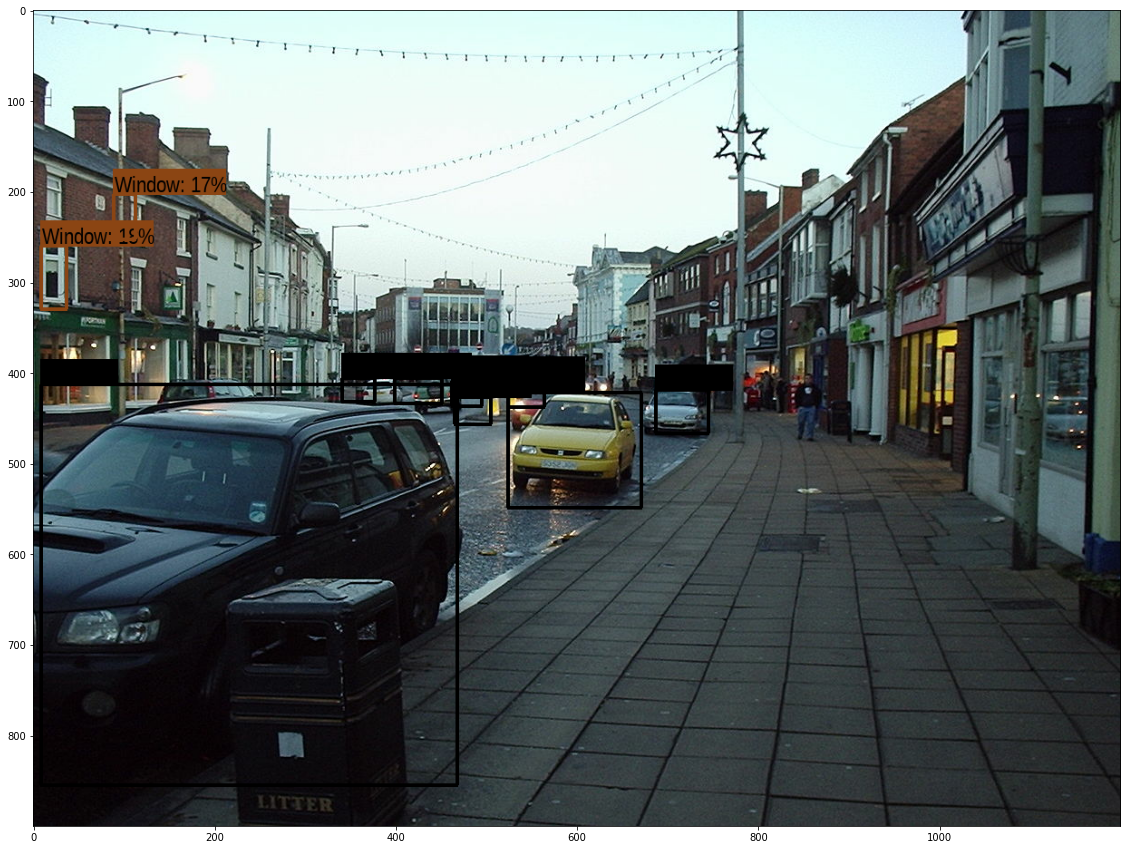

In [68]:
result_10 = run_detector(detector, List_name[0])

In [69]:
result_10

{'detection_class_names': array([b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j', b'/m/0k4j',
        b'/m/0k4j', b'/m/0k4j', b'/m/0d4v4', b'/m/0k4j', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0k4j', b'/m/03jm5', b'/m/0cgh4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/01jfm_', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0cgh4', b'/m/0d4v4', b'/m/03jm5',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0k4j', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0k4j', b'/m/0k4j',
        b'/m/0cgh4', b'/m/0d4v4', b'/m/0d4v4', b'/m/0d4v4', b'/m/083wq',
        b'/m/0d4v4', b'/m/0d4v4', b'/m/0c

In [70]:
result_10 = run_detector(detector, List_name[1])

Output hidden; open in https://colab.research.google.com to view.

In [71]:
result_10 = run_detector(detector, List_name[2])

Output hidden; open in https://colab.research.google.com to view.